# STAT 301 - Final Group Project
---

## Pricing Budapest: A Predictive Analysis of Airbnb Listings


**Group Number:** 13 

**Group Members:** Sama Patnaik, Karl Estampador, Saanvi Bhalla, Samantha Yano

**Course:** STAT 301 

**Date:** Dec 6th 2025

# Introduction
---

In recent years, Airbnb has become one of the most popular ways for visitors to find short term accommodation in major cities. Budapest is no exception as a large number of private hosts and both professional and business oriented hosts now list their entire apartments, private rooms, and shared spaces across the city. This topic is interesting to follow both from a practical and a broader social perspective. For travellers, understanding what drives Airbnb prices can help them compare options and plan affordable trips. Meanwhile, for hosts and policymakers, price patterns can shed light on how different types of listings and neighbourhoods participate in the local tourism economy.

At a broader level, short term rentals (STRs) like Airbnb have grown into an important part of the accommodation sector. For example, a Statistics Canada study using AirDNA data and business survey data, found that private STRs’ share of revenue in the Canadian accommodation services subsector more than doubled from 7.0% in 2017 to 15.2% in 2021, with even higher shares in major tourist regions (Bernard & Vipond, 2023). 

This highlights how platforms such as Airbnb are no longer a niche option but have become a substantial competitor to traditional hotels. At the city scale, Taltavull de La Paz et al. (2023) use Airbnb microdata for 39 European cities and show that short term rental markets exhibit synchronized movements in supply, bookings, and prices over time, behaving in many ways like housing markets and revealing strong cross city linkages. Together, these studies suggest that Airbnb pricing is shaped by both local listing characteristics and broader market dynamics.

In this project, we use Airbnb data from Budapest to explore how the total cost of a two night stay is associated with characteristics of the listing, the host, the surrounding area and more. Our main research question is:

> **How well can we predict the total price of a two-night stay (for two guests) using listing, host, and location features, including whether the listing is business-oriented or privately hosted?**

Our response variable is realSum, which is the total price for two guests over two nights. Key predictors include biz (whether the listing is flagged as a business listing), room type, various rating scores, attraction and location indices, distances to points of interest, and other listing characteristics. The primary focus of this project is prediction where we aim to build a model that can accurately predict realSum and provide interpretations, without making causal claims about the “effect” of any variable.

By situating our analysis alongside national level evidence on STR revenue growth and city wide work on Airbnb price dynamics, we contribute a specific case study on Budapest that zooms in on how different features relate to listing prices.

**General Roadmap:** 

In this report, we first conduct the data and exploratory analyses (EDA), then present several predictive models for realSum and compare their performance, and finally discuss the implications and limitations of our findings for Airbnb guests, hosts, and future research.

# Data & EDA 
---

The premise and background of the project have been set up, we will now focus on the importing libraries, conducting EDA and preprocessing the dataset for our predictive model. 

In [1]:
install.packages("stargazer")

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [2]:

# Core data wrangling and visualization:
library(tidyverse)

# For combining multiple ggplot2 plots into a single figure
library(patchwork)

# For converting model objects into tidy data frames
library(broom)

# For generating nicely formatted regression tables (HTML, LaTeX, text)
library(stargazer)

# for splitting data, preprocessing (recipes), model specification, tuning, and evaluation
library(tidymodels)

# For fitting penalized regression models
library(glmnet)

# For multiple plots
library(cowplot)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Please cite as: 


 Hlavac, Marek (2022). stargazer: Well-Formatted Regression and Summary Statistics Tables.

 R package version 5.2.3. https://CRAN.R-project.org/package=stargazer 


── Attaching packages ────────────────────────────────────── tidymodels 1.2.0 ──

✔ dials        1.2.1     ✔ rsample      1.2.1
✔ infer        1.0.7     ✔ tune         1.2.1
✔ modeldata    1.4.0     ✔ workflows    1.1.4
✔ parsnip      1.2.1     ✔ workflowsets 1.1.0
✔ recipes      1.1.0    

In [3]:
# Reading both Budapest datasets for weekdays and weekends
weekdays <- read_csv("data/budapest_weekdays.csv")
weekends <- read_csv("data/budapest_weekends.csv")

# Adding the day_type variable to each dataset to indicate which dataset each observation comes from
weekdays <- mutate(weekdays, day_type = 'weekdays')
weekends <- mutate(weekends, day_type = 'weekends')

# Combining the 2 datasets into 1 by making a single identifier column called day_type
budapest_data <- bind_rows(weekdays, weekends) |>
    mutate(day_type = as.factor(day_type))

head(budapest_data)

New names:
• `` -> `...1`
Rows: 2074 Columns: 20
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): room_type
dbl (16): ...1, realSum, person_capacity, multi, biz, cleanliness_rating, gu...
lgl  (3): room_shared, room_private, host_is_superhost

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
New names:
• `` -> `...1`
Rows: 1948 Columns: 20
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): room_type
dbl (16): ...1, realSum, person_capacity, multi, biz, cleanliness_rating, gu...
lgl  (3): room_shared, room_private, host_is_superhost

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


...1 realSum  room_type       room_shared room_private person_capacity
1 0    238.9905 Entire home/apt FALSE       FALSE        6              
2 1    300.7943 Entire home/apt FALSE       FALSE        6              
3 2    162.3819 Entire home/apt FALSE       FALSE        4              
4 3    118.4377 Entire home/apt FALSE       FALSE        2              
5 4    134.4174 Entire home/apt FALSE       FALSE        4              
6 5    127.3676 Entire home/apt FALSE       FALSE        4              
  host_is_superhost multi biz cleanliness_rating ⋯ bedrooms dist     
1  TRUE             0     1   10                 ⋯ 1        0.3593550
2 FALSE             0     1    9                 ⋯ 2        0.9294272
3  TRUE             0     0   10                 ⋯ 1        2.4508403
4 FALSE             0     0    9                 ⋯ 1        1.5594494
5  TRUE             1     0   10                 ⋯ 2        1.1138030
6 FALSE             1     0    9                 ⋯ 2        0.2684703
  metro_dist attr_index attr_index_norm rest_index rest_index_norm lng     
1 0.3526430   404.4047   24.116552       893.4773  67.65685        19.05074
2 0.2002355  1676.8760  100.000000       452.5397  34.26770        19.04493
3 0.2794518   163.5885    9.755551       191.9923  14.53825        19.02170
4 0.4779711   191.7198   11.433155       326.2156  24.70205        19.06301
5 0.2701016   198.6035   11.843658       635.5159  48.12322        19.06900
6 0.1669317   635.6350   37.905903      1005.6535  76.15118        19.05480
  lat      day_type
1 47.50076 weekdays
2 47.50405 weekdays
3 47.49882 weekdays
4 47.51126 weekdays
5 47.49900 weekdays
6 47.50094 weekdays

## Data Description

The dataset being explored in this report is the Airbnb Prices in European Cities, specifically in Budapest, Hungary. The data contains multiple variables collected from Airbnb listings and their various attributes about different listings. There are 2 dataset files, split into weekday data and weekend data, each containing the same columns. Both datasets have 20 columns. In the weekday data, there are 2074 observations, and in the weekend data, there are 1948 observations, for a total of 4022 observations in total. The datasets for weekday and weekend were combined into one cohesive dataset, containing a new variable `day_type` to indicate which initial dataset the listing came from.

### Variable Summary

| Variable                     |     Type    |                                                 Description |
| :--------------------------- | :---------: | ----------------------------------------------------------: |
| `...1`                       |   Numeric   |         The added variable increasing with each observation |
| `realSum`                    |   Numeric   |                       The total price of the Airbnb listing |
| `room_type`                  | Categorical | The type of room being offered (e.g. private, shared, etc.) |
| `room_shared`                |   Boolean   |                           Whether the room is shared or not |
| `room_private`               |   Boolean   |                          Whether the room is private or not |
| `person_capacity`            |   Numeric   |      The maximum number of people that can stay in the room |
| `host_is_superhost`          |   Boolean   |                      Whether the host is a superhost or not |
| `multi`                      |   Boolean   |            Whether the listing is for multiple rooms or not |
| `biz`                        |   Boolean   |         Whether the listing is for business purposes or not |
| `cleanliness_rating`         |   Numeric   |                       The cleanliness rating of the listing |
| `guest_satisfaction_overall` |   Numeric   |        The overall guest satisfaction rating of the listing |
| `bedrooms`                   |   Numeric   |                       The number of bedrooms in the listing |
| `dist`                       |   Numeric   |                           The distance from the city centre |
| `metro_dist`                 |   Numeric   |                 The distance from the nearest metro station |
| `lng`                        |   Numeric   |                                The longitude of the listing |
| `lat`                        |   Numeric   |                                 The latitude of the listing |
| `id`                         |   Numeric   |                            The ID number of the observation |
| `attr_index`                 |   Numeric   |                                        The attraction index |
| `attr_index_norm`            |   Numeric   |                             The normalized attraction index |
| `rest_index`                 |   Numeric   |                                        The restaurant index |
| `rest_index_norm`            |   Numeric   |                             The normalized restaurant index |
| `day_type`                   | Categorical |   The type of day the listing falls on (weekend or weekday) |

#### Source and Information
This data was taken from Airbnb, and each listing was evaluated for various attributes as seen above. One thing to note is that the dataset does not give a full description for attraction index or restaurant index passed their full names. 
The dataset being used is linked here: https://www.kaggle.com/datasets/thedevastator/airbnb-prices-in-european-cities?select=budapest_weekdays.csv

#### Variable Selection
The goal of this model is to predict the response variable, `realSum`; therefore, there will not be any variables dropped in pre-selection. 

### Data Summaries

In [4]:
# First, check for NAs & print total rows of NAs ----
# total number of NA cells
total_na_cells <- sum(is.na(budapest_data))
cat("Total number of NA cells:", total_na_cells, "\n")

# number of rows that contain at least one NA
rows_with_na <- sum(!complete.cases(budapest_data))
cat("Rows with at least one NA: ", rows_with_na, "\n")


# Check for duplicates in dataset & print total duplicates ----
# number of unique rows
n_unique <- nrow(distinct(budapest_data))
cat("Number of unique rows: ", n_unique, "\n")

# total number of duplicate rows
n_duplicates <- nrow(budapest_data) - n_unique
cat("Number of duplicate rows: ", n_duplicates, "\n\n")

# use summary() to find summary statistics 
summary(budapest_data)

Total number of NA cells: 0 
Rows with at least one NA:  0 
Number of unique rows:  4022 
Number of duplicate rows:  0 



      ...1           realSum         room_type         room_shared    
 Min.   :   0.0   Min.   :  34.78   Length:4022        Mode :logical  
 1st Qu.: 502.2   1st Qu.: 125.25   Class :character   FALSE:4008     
 Median :1005.0   Median : 152.98   Mode  :character   TRUE :14       
 Mean   :1006.0   Mean   : 176.51                                     
 3rd Qu.:1507.8   3rd Qu.: 198.34                                     
 Max.   :2073.0   Max.   :3751.23                                     
 room_private    person_capacity host_is_superhost     multi       
 Mode :logical   Min.   :2.000   Mode :logical     Min.   :0.0000  
 FALSE:3603      1st Qu.:2.000   FALSE:2498        1st Qu.:0.0000  
 TRUE :419       Median :4.000   TRUE :1524        Median :0.0000  
                 Mean   :3.541                     Mean   :0.3033  
                 3rd Qu.:4.000                     3rd Qu.:1.0000  
                 Max.   :6.000                     Max.   :1.0000  
      biz         cleanline

As seen above, this dataset does not contain any missing values or duplicates, which makes this dataset ideal for a prediction model. The prices in `realSum` range from €34.78 to €3,751.23, with a median price of €152.98 and an average cost of €176.51. As we are training a prediction model, this summary can help us better understand the data, but it will not give us insight as to which features will be most important in our model.

## Exploratory Data Analysis (EDA)

In [5]:
# Converting variables to their proper types
budapest_data <- budapest_data %>%
    mutate(
        realSum = as.numeric(realSum),
        room_type = as.factor(room_type),
        person_capacity = as.numeric(person_capacity),
        host_is_superhost = as.factor(host_is_superhost),
        multi = if_else(multi == 0, FALSE, TRUE),
        multi = as.factor(multi),
        biz = if_else(biz == 1, TRUE, FALSE),
        biz = as.factor(biz),
        cleanliness_rating = as.numeric(cleanliness_rating),
        guest_satisfaction_overall = as.numeric(guest_satisfaction_overall),
        bedrooms = as.numeric(bedrooms),
        dist = as.numeric(dist),
        metro_dist = as.numeric(metro_dist),
        attr_index_norm = as.numeric(attr_index_norm),
        rest_index_norm = as.numeric(rest_index_norm),
        day_type = as.factor(day_type)
    )

# # Removing NA values
# budapest_data <- budapest_data |>
#                     drop_na()
head(budapest_data)

...1 realSum  room_type       room_shared room_private person_capacity
1 0    238.9905 Entire home/apt FALSE       FALSE        6              
2 1    300.7943 Entire home/apt FALSE       FALSE        6              
3 2    162.3819 Entire home/apt FALSE       FALSE        4              
4 3    118.4377 Entire home/apt FALSE       FALSE        2              
5 4    134.4174 Entire home/apt FALSE       FALSE        4              
6 5    127.3676 Entire home/apt FALSE       FALSE        4              
  host_is_superhost multi biz   cleanliness_rating ⋯ bedrooms dist     
1 TRUE              FALSE TRUE  10                 ⋯ 1        0.3593550
2 FALSE             FALSE TRUE   9                 ⋯ 2        0.9294272
3 TRUE              FALSE FALSE 10                 ⋯ 1        2.4508403
4 FALSE             FALSE FALSE  9                 ⋯ 1        1.5594494
5 TRUE              TRUE  FALSE 10                 ⋯ 2        1.1138030
6 FALSE             TRUE  FALSE  9                 ⋯ 2        0.2684703
  metro_dist attr_index attr_index_norm rest_index rest_index_norm lng     
1 0.3526430   404.4047   24.116552       893.4773  67.65685        19.05074
2 0.2002355  1676.8760  100.000000       452.5397  34.26770        19.04493
3 0.2794518   163.5885    9.755551       191.9923  14.53825        19.02170
4 0.4779711   191.7198   11.433155       326.2156  24.70205        19.06301
5 0.2701016   198.6035   11.843658       635.5159  48.12322        19.06900
6 0.1669317   635.6350   37.905903      1005.6535  76.15118        19.05480
  lat      day_type
1 47.50076 weekdays
2 47.50405 weekdays
3 47.49882 weekdays
4 47.51126 weekdays
5 47.49900 weekdays
6 47.50094 weekdays

corrplot 0.92 loaded



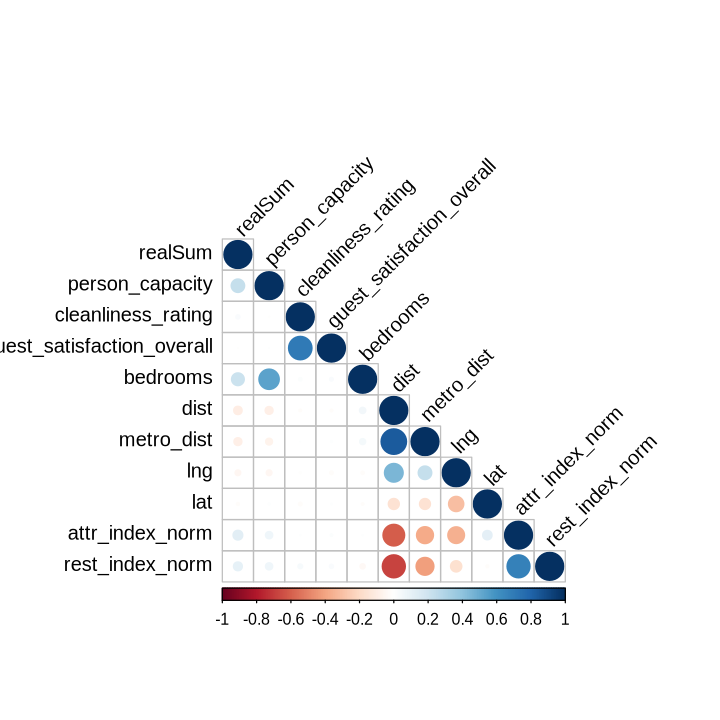

In [6]:
options(repr.plot.width = 6, repr.plot.height = 6)  # set the size 

# correlation matrix plot to visualize the relationships between the variables better
cont_vars <- budapest_data |>
  select(realSum, person_capacity, cleanliness_rating,
         guest_satisfaction_overall, bedrooms, dist, metro_dist, lng, lat,
         attr_index_norm, rest_index_norm)

cor_mat <- cor(cont_vars, use = "complete.obs")
# for the correlation heatmap
library(corrplot)
corrplot(cor_mat, type = "lower",
         tl.col = "black", tl.srt = 45)

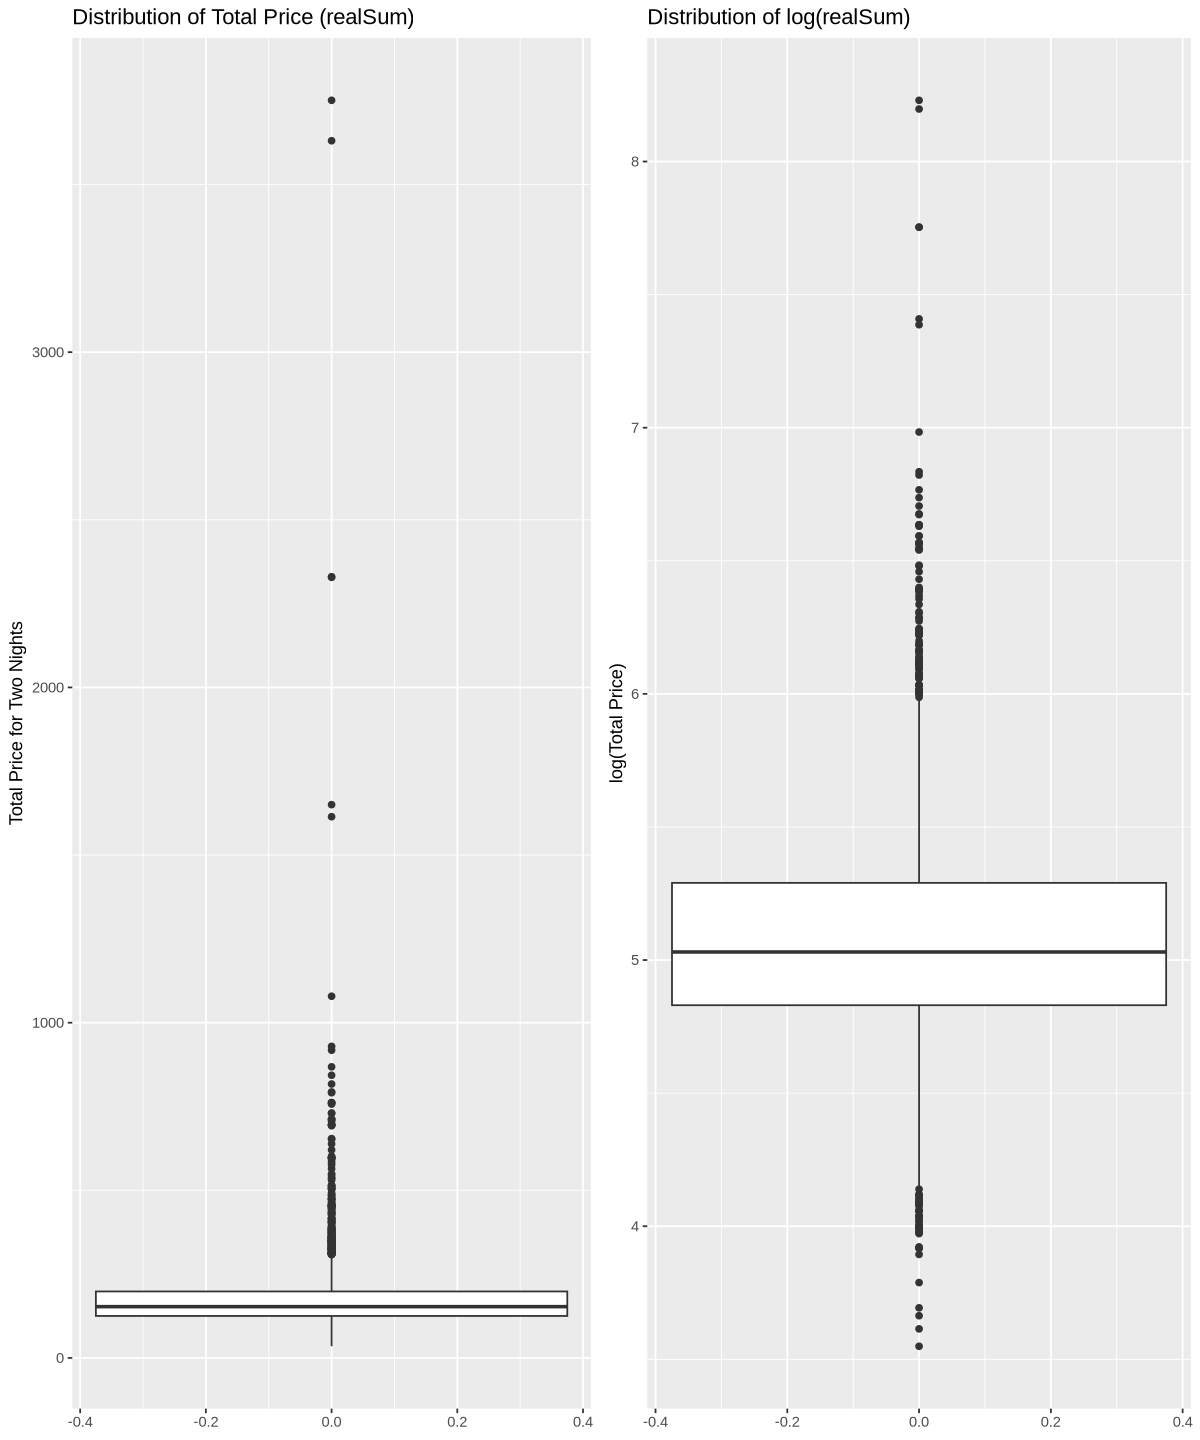

In [7]:
# Boxplots to identify outliers in price

options(repr.plot.width = 10, repr.plot.height = 12)

# Basic boxplot of price to understand price distribution on the normal scale and the log scale 
p1 <- ggplot(budapest_data, aes(y = realSum)) +
  geom_boxplot() +
  labs(
    title = "Distribution of Total Price (realSum)",
    y = "Total Price for Two Nights"
  )


p2 <- ggplot(budapest_data, aes(y = log(realSum))) +
  geom_boxplot() +
  labs(
    title = "Distribution of log(realSum)",
    y = "log(Total Price)"
  )

plot_grid(p1, p2, nrow = 1) #plot them side by side 

As seen above, the boxplot of realSum on the left shows a heavily right skewed distribution of prices which means that most listings had relatively low prices, while a small number of listings had extremely high prices (long upper whisker and many high outliers). This indicates strong skewness and the presence of influential outliers on the original price scale. After applying a log transformation on the right, the distribution of log(realSum) becomes much more compressed and symmetric. The extreme high price outliers are pulled closer to the main bulk of the data, and the spread around the median is more balanced.

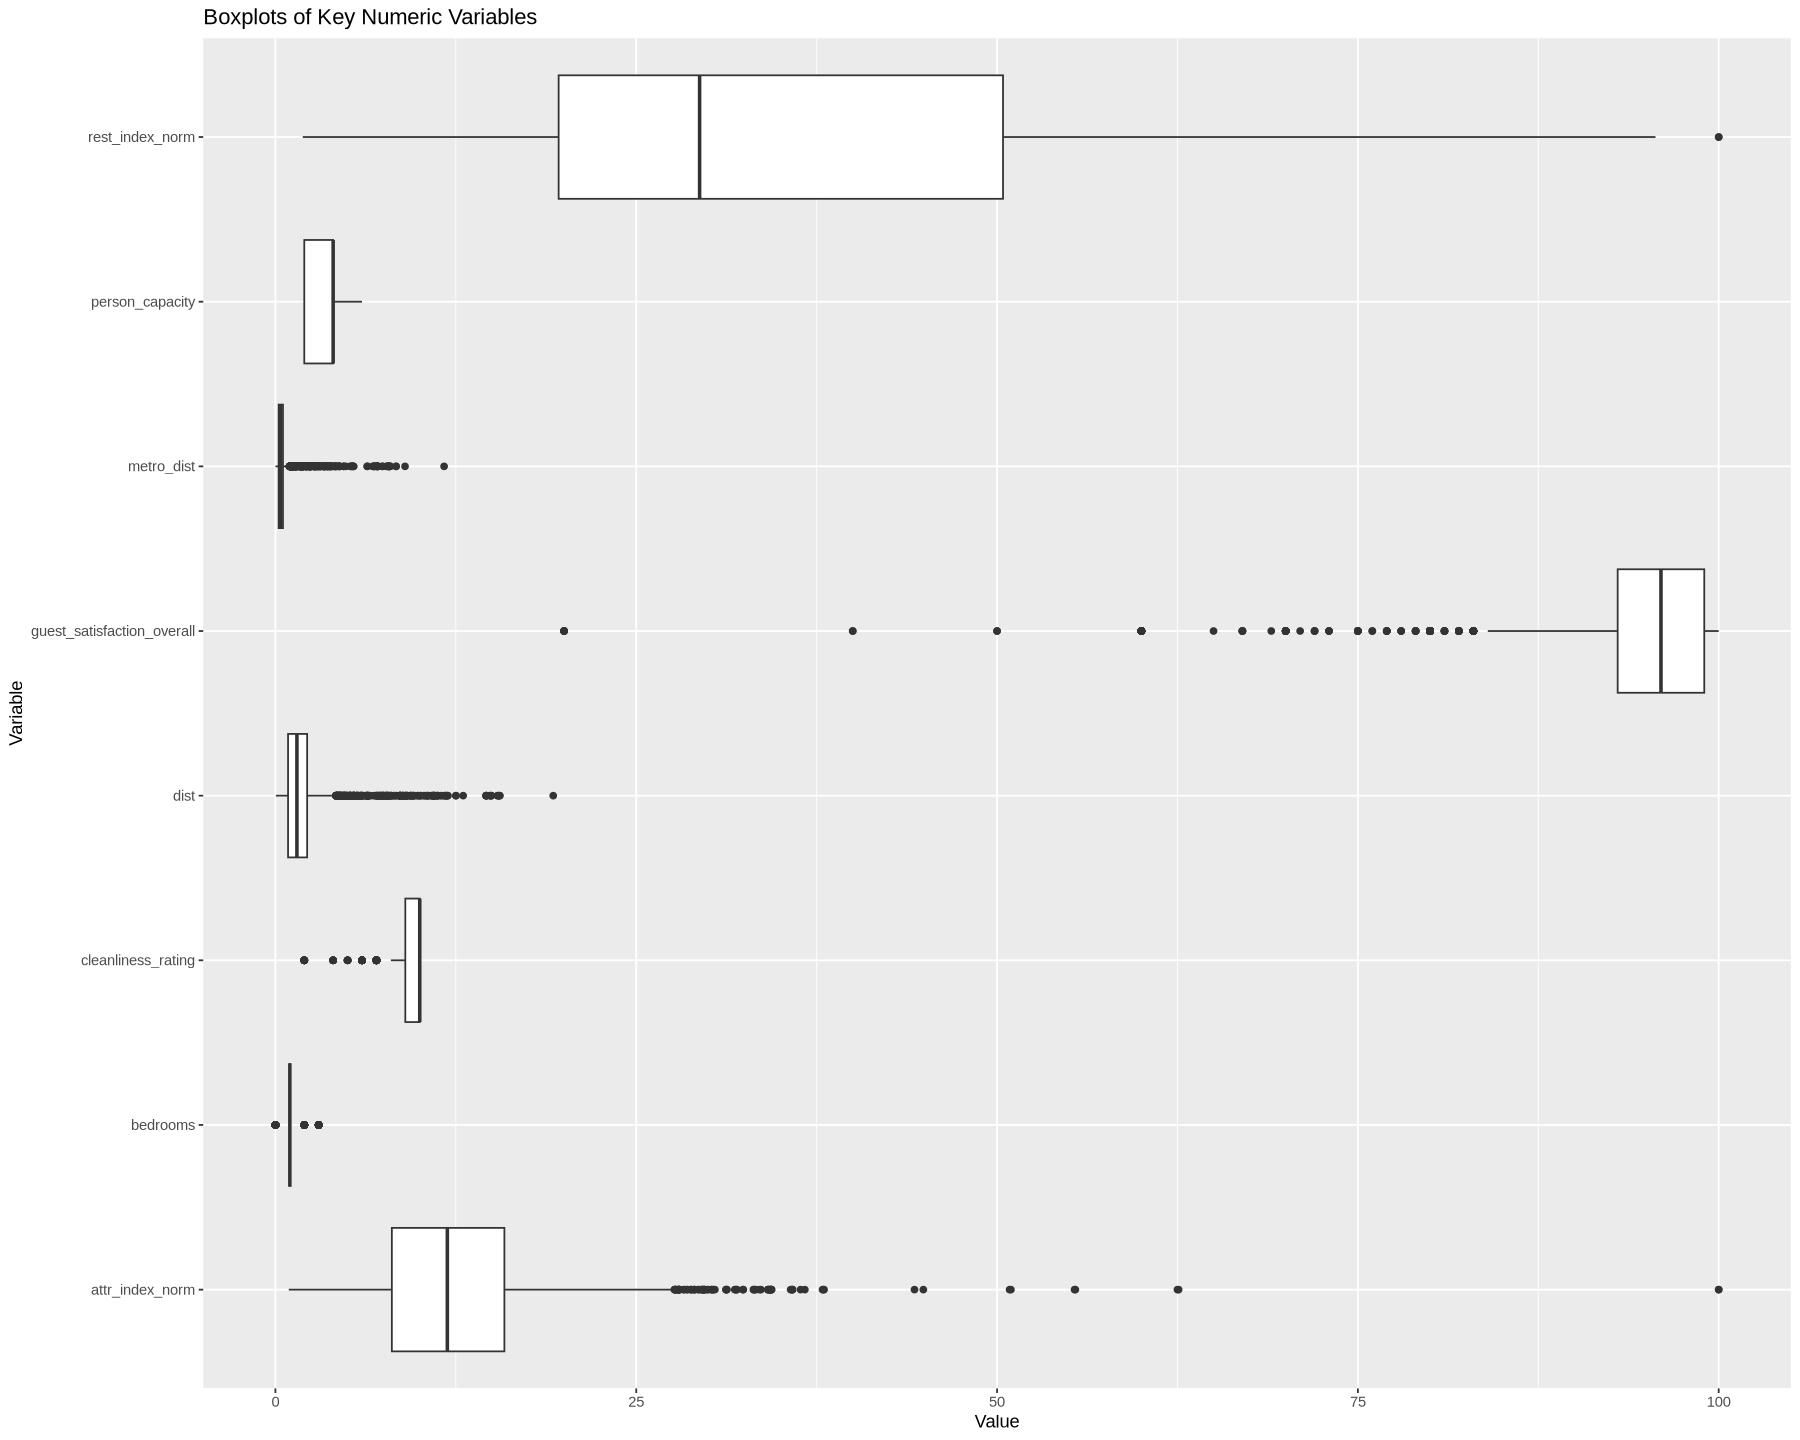

In [8]:
# Boxplots to identify outliers in all other variables 

options(repr.plot.width = 15, repr.plot.height = 12) # 

# select the variables of interest
num_vars <- c(
  "person_capacity",
  "cleanliness_rating",
  "guest_satisfaction_overall",
  "bedrooms",
  "dist",
  "metro_dist",
  "attr_index_norm",
  "rest_index_norm"
)

# multi boxplot
budapest_data |>
  select(all_of(num_vars)) |>
  pivot_longer(cols = everything(), names_to = "variable", values_to = "value") |>
  ggplot(aes(x = variable, y = value)) +
  geom_boxplot() +
  coord_flip() +
  labs(
    title = "Boxplots of Key Numeric Variables",
    x = "Variable",
    y = "Value"
  )

The boxplots of the key numeric variables show quite different patterns of spread and outliers across features. Bedrooms and person_capacity are both highly concentrated at low values (1–2 bedrooms, small capacities) with a few larger listings acting as upper outliers, which reflects the dominance of small apartments in the dataset. Cleanliness_rating and guest_satisfaction_overall are left-skewed and tightly packed near the upper end of their scales, suggesting that most listings receive high ratings with only a handful of poorly rated units. In contrast, dist and metro_dist display long right tails: while many listings are relatively close to the city centre and metro stations, some are located much farther away, which could contribute to price differences. Finally, attr_index_norm and rest_index_norm show substantial variation, with a few extreme outliers at both low and high values, indicating that listings are located in neighbourhoods with very different levels of attraction and restaurant density. Overall, these patterns highlight several variables with skewness and outliers that our modelling strategy (e.g., transformations and regularization) needs to accommodate.

<h3>Visualisations</h3>

`geom_smooth()` using formula = 'y ~ x'


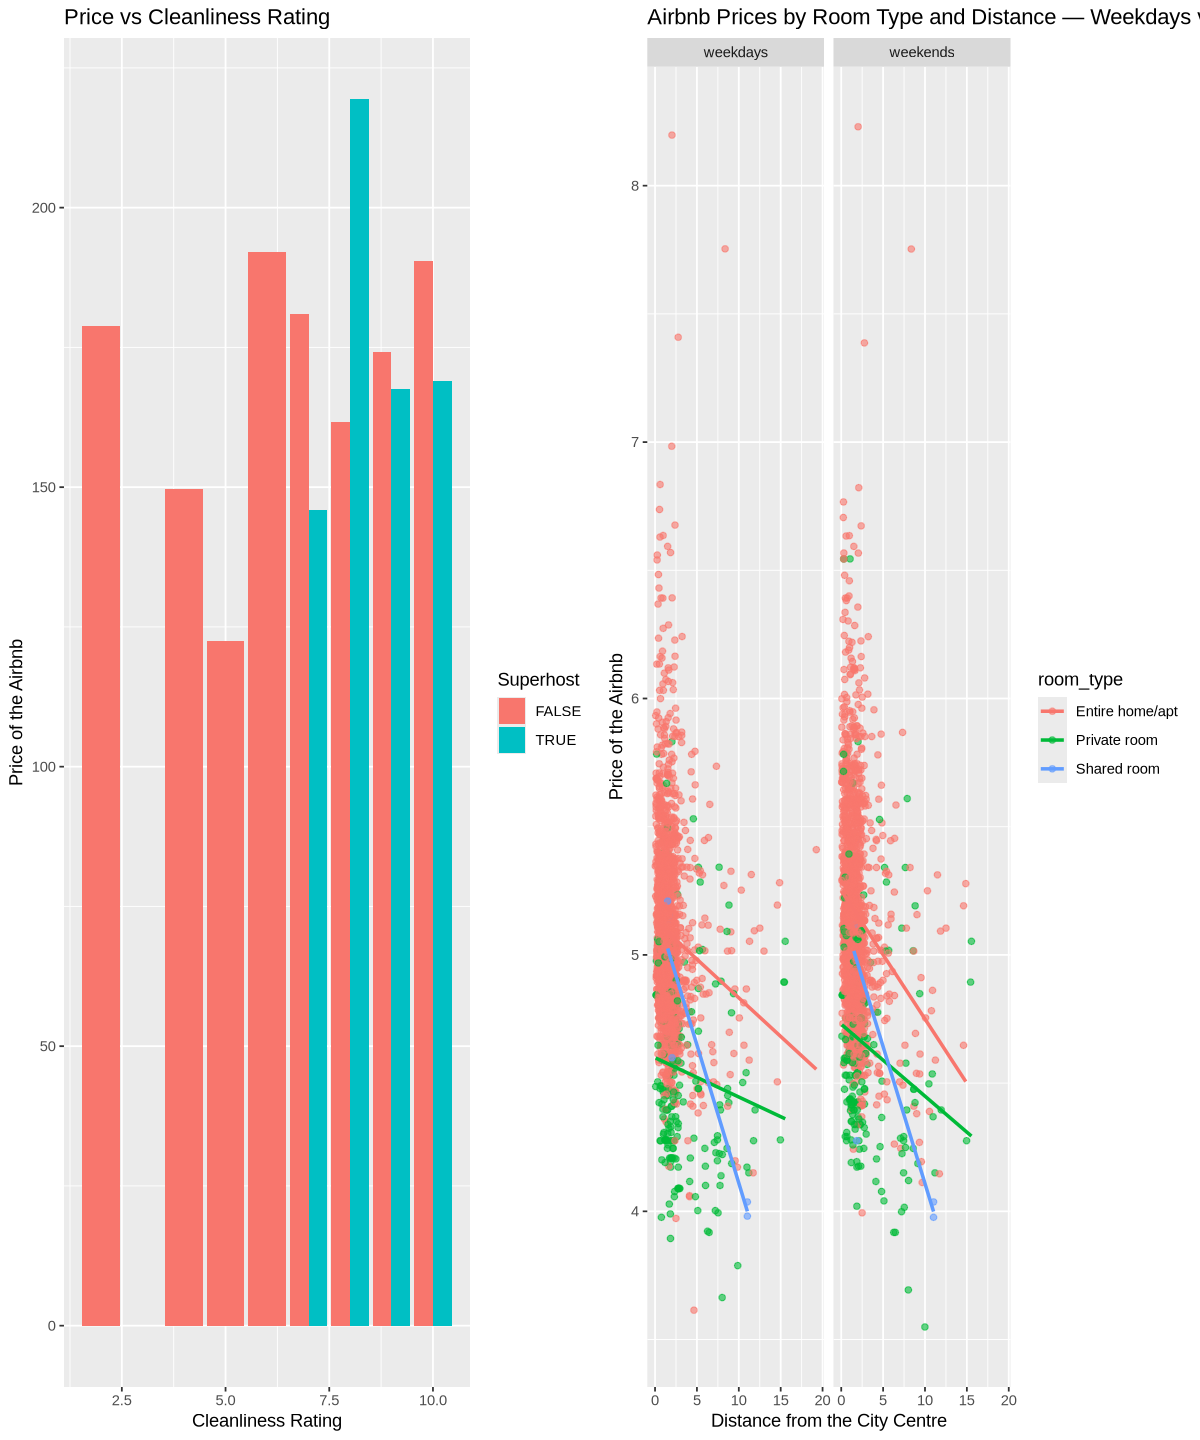

In [9]:
options(repr.plot.width = 10, repr.plot.height = 12)

avg_price <- budapest_data |>
  group_by(cleanliness_rating, host_is_superhost) |>
  summarise(mean_price = mean(realSum, na.rm = TRUE), .groups = "drop")

plot <- plot_a <- ggplot(avg_price,
    aes(x = cleanliness_rating,y = mean_price,fill = host_is_superhost)) +
    geom_col(position = "dodge") +
    labs(title = "Price vs Cleanliness Rating",
        x = "Cleanliness Rating",
        y = "Price of the Airbnb",
        fill = "Superhost") 


plot2 <- ggplot(budapest_data, aes(x = dist, y = log(realSum), color = room_type)) +
      geom_point(alpha = 0.6) +
      geom_smooth(method = "lm", se = FALSE) +
      facet_wrap(~ day_type,
                 labeller = labeller(day_type = c(`0` = "Weekdays", `1` = "Weekends`"))) +
      xlab("Distance from the City Centre") +
      ylab("Price of the Airbnb") +
      ggtitle("Airbnb Prices by Room Type and Distance — Weekdays vs Weekends")

plot_grid(plot, plot2)

For plot 2, we applied a log transformation so that the distribution of points appears more balanced and easier to interpret.
Furthermore, room types are separated more clearly on the log scale.

# Methods and Results
---

## Methods Plan

To answer our question, we will use `realSum` as our response variable, which represents the total price of the Airbnb listing. Our candidate predictors include all of the remaining variables, allowing us to create a statistical model that will allow us to analyze the factors that drive Airbnb listing prices. We have decided to include all of the remaining variables since our goal is predicting Airbnb prices, as we are using LASSO for variable selection.

In order to predict the total price of Airbnb listings based on the listing's characteristics, we have fitted the following candidate models, where we will run a LASSO regression on one of the models based on model fit, which indicates the model's stronger predictive performance:
1) An Ordinary Least Squares (OLS) model with `realSum`.
2) An OLS model with `log(realSum)` to address skewness.
3) An OLS model with selected, domain-motivated interactions to capture non-additive effects.

To start, OLS provides an interpretable baseline for understanding the association between total price and various listing features. Log-transforming the response stabilizes variance and yields percentage changes in price, hence improving model fit. This is because based on our domain knowledge in economics, price variables are often right-skewed. Next, adding interactions allows us to detect conditional effects, such as how location modifies other predictors. This allows the model to capture non-additive relationships, supporting a better understanding of how these interactons are associated with total price.

Afterwards, we used LASSO regression for variable selection and prediction because it regularizes coefficient estimates and performs feature selection, which improves out-of-sample accuracy. To start, we split the dataset into training and testing sets, with 80% of the data assigned to the training set and the remaining data assigned to the testing set. Afterwards, the tuning parameter $\lambda$ was determined by ten-fold cross-validation performed on the training sample, based on the lowest RMSE value.

From there, we will evaluate fit and compare OLS models through adjusted $R^2$, residual standard error, and other  specification diagnostics, which assess explained variation explained while penalizing unnecessary complexity, highlight residual behaviour, and help determine whether predictors offer meaningful explanatory power.

## Code and Results

In [10]:
# We set the seed here:
set.seed(2025)

# We start by building the first model:
model1 <- lm(realSum ~ . , data = budapest_data)
tidy1 <- tidy(model1)

# Now, we build the second model by logarithmically transforming `realSum`:
model2 <- lm(log(realSum) ~ . , data = budapest_data)
tidy2 <- tidy(model2)

# We add interactions to build the third model:
model3 <- lm(log(realSum) ~ . + dist*metro_dist + dist*attr_index_norm +
      host_is_superhost*room_type + host_is_superhost*cleanliness_rating +
      room_type*person_capacity + room_type*bedrooms ,
    data = budapest_data)
tidy3 <- tidy(model3)

stargazer(model1, model2, model3, 
          type = "text",
         title = "Figure 1: OLS Regression Results for Budapest Airbnb Prices")


Figure 1: OLS Regression Results for Budapest Airbnb Prices
                                                                      Dependent variable:                              
                                         ------------------------------------------------------------------------------
                                                  realSum                              log(realSum)                    
                                                    (1)                       (2)                        (3)           
-----------------------------------------------------------------------------------------------------------------------
...1                                             0.018***                  0.0001***                  0.0001***        
                                                  (0.004)                  (0.00001)                  (0.00001)        
                                                                                                   

Figure 1 shows that using `log(realSum)` as our response variable and adding interactions produces the highest adjusted $R^2$ value. Hence, based on the results and on the interactions added in the model, we will select the third model to run a LASSO regression.

In [11]:
# Finally, we create a LASSO regression to create a strong predictive model for `realSum`, as we use model3 since it has the highest R^2 & adjusted R^2 values, and a lower residual standard error:

# we start by splitting the budapest data into 80/20 split
budapest_split <- initial_split(budapest_data, prop = 0.8, strata = realSum)
budapest_selection <- training(budapest_split)
budapest_inference <- testing(budapest_split)

# we prepare x and y for training, added interaction variables i thought were useful, removed price quintiles
x_train <- model.matrix(
    log(realSum) ~ . + dist*metro_dist + dist*attr_index_norm +
      host_is_superhost*room_type + host_is_superhost*cleanliness_rating +
      room_type*person_capacity + room_type*bedrooms ,
    data = budapest_selection
)[,-1]
y_train <- log(budapest_selection$realSum)   # log-price

# we fit LASSO with cross-validation
lasso_cv <- cv.glmnet(x = x_train, y = y_train, alpha = 1, nfolds = 10)

# we have coefficients at lambda.min (tidy)
beta_mat <- as.matrix(coef(lasso_cv, s = "lambda.min"))
coef_tbl <- as_tibble(beta_mat, rownames = "covariate") %>%
  rename(estimate = s1) %>%
  filter(covariate != "(Intercept)") %>% # selects covariates
  mutate(selected = estimate != 0,
         pct_change = (exp(estimate) - 1) * 100) %>%
  arrange(desc(abs(estimate)))

# we keep only selected (non-zero) covariates, and round estimate and pct_change
selected_tbl <- coef_tbl %>% filter(selected) %>%
  mutate(estimate = round(estimate, 4),
         pct_change = round(pct_change, 2))

# we compute test predictions and RMSE on original price scale
x_test <- model.matrix(
    log(realSum) ~ . + dist*metro_dist + dist*attr_index_norm +
      host_is_superhost*room_type + host_is_superhost*cleanliness_rating +
      room_type*person_capacity + room_type*bedrooms ,
    data = budapest_inference
)[,-1]
pred_log <- predict(lasso_cv, newx = x_test, s = "lambda.min")
pred_price <- exp(as.vector(pred_log)) # since we log transformed realSum

# compute test RMSE
rmse_test_price <- sqrt(mean((pred_price - budapest_inference$realSum)^2)) 

# create final table without test RMSE
model4_results <- selected_tbl %>%
  select(covariate, estimate, pct_change) %>%
  rename(
    `Covariate` = covariate,
    `LASSO coef (log-price)` = estimate,
    `Approx % change in price` = pct_change
  ) %>%
  mutate(`Approx % change in price` = paste0(`Approx % change in price`, "%"))

# print the table
cat("Figure 2: LASSO Regression Coefficients for Budapest Airbnb Prices\n\n")
model4_results

# print test RMSE separately (not in the table)
cat("\nTest RMSE (price scale):", round(rmse_test_price, 2), "\n")


Figure 2: LASSO Regression Coefficients for Budapest Airbnb Prices



Covariate                                   LASSO coef (log-price)
1  lng                                         -1.9951               
2  room_typePrivate room                       -0.4590               
3  room_typeShared room                         0.3747               
4  room_typeShared room:person_capacity        -0.2208               
5  lat                                         -0.2135               
6  bedrooms                                     0.1142               
7  metro_dist                                  -0.1034               
8  person_capacity                              0.0628               
9  day_typeweekends                             0.0551               
10 multiTRUE                                   -0.0364               
11 room_typePrivate room:person_capacity        0.0322               
12 cleanliness_rating                           0.0316               
13 bizTRUE                                      0.0238               
14 room_typeShared room:bedrooms                0.0229               
15 room_typePrivate room:host_is_superhostTRUE  0.0188               
16 room_typePrivate room:bedrooms              -0.0082               
17 rest_index_norm                              0.0081               
18 dist:attr_index_norm                        -0.0076               
19 dist                                         0.0074               
20 dist:metro_dist                              0.0073               
21 guest_satisfaction_overall                  -0.0028               
22 host_is_superhostTRUE:cleanliness_rating    -0.0023               
23 attr_index_norm                              0.0022               
24 rest_index                                  -0.0009               
25 attr_index                                   0.0008               
26 ...1                                         0.0001               
27 room_privateTRUE                             0.0000               
28 room_sharedTRUE                              0.0000               
   Approx % change in price
1  -86.4%                  
2  -36.81%                 
3  45.45%                  
4  -19.81%                 
5  -19.23%                 
6  12.09%                  
7  -9.83%                  
8  6.48%                   
9  5.66%                   
10 -3.58%                  
11 3.28%                   
12 3.21%                   
13 2.41%                   
14 2.32%                   
15 1.9%                    
16 -0.81%                  
17 0.82%                   
18 -0.75%                  
19 0.75%                   
20 0.74%                   
21 -0.28%                  
22 -0.22%                  
23 0.22%                   
24 -0.09%                  
25 0.08%                   
26 0.01%                   
27 0%                      
28 0%


Test RMSE (price scale): 71.07 


The results from Figure 2 show that location and room type are significant factors in predicting price, and that the test RMSE is 71.07, indicating reasonable predictive performance.

In [12]:
# Figure 3: Model Performance on Held-out Test Set (Budapest Airbnb)

# Helper functions for metrics
rmse <- function(actual, predicted) sqrt(mean((actual - predicted)^2))
mae  <- function(actual, predicted) mean(abs(actual - predicted))
r2_test <- function(actual, predicted) {
  1 - sum((actual - predicted)^2) / sum((actual - mean(actual))^2)
}

# Compute predictions on test set
actual_test <- budapest_inference$realSum

# LM3 predictions (log scale back-transformed)
pred_lm3_log_test <- predict(model3, newdata = budapest_inference)
pred_lm3_test <- exp(as.vector(pred_lm3_log_test))

# LASSO predictions (log scale back-transformed)
x_test <- model.matrix(
  log(realSum) ~ . + dist*metro_dist + dist*attr_index_norm +
    host_is_superhost*room_type + host_is_superhost*cleanliness_rating +
    room_type*person_capacity + room_type*bedrooms,
  data = budapest_inference
)[,-1, drop = FALSE]

pred_lasso_log <- predict(lasso_cv, newx = x_test, s = "lambda.min")
pred_lasso_test <- exp(as.vector(pred_lasso_log))

# Count number of predictors
num_predictors_lm3 <- length(coef(model3)) - 1  # exclude intercept
num_predictors_lasso <- sum(coef(lasso_cv, s = "lambda.min")[-1] != 0)  # non-zero excluding intercept

# Create metrics table
metrics_final <- tibble(
  Model = c("LM model3", "LASSO model3"),
  `# Predictors` = c(num_predictors_lm3, num_predictors_lasso),
  `RMSE (Price)` = c(
    rmse(actual_test, pred_lm3_test),
    rmse(actual_test, pred_lasso_test)
  ),
  `MAE (Price)` = c(
    mae(actual_test, pred_lm3_test),
    mae(actual_test, pred_lasso_test)
  ),
  `R^2 (Test)` = c(
    r2_test(actual_test, pred_lm3_test),
    r2_test(actual_test, pred_lasso_test)
  ),
  Notes = c(
    "Log transformation of price + interactions",
    "LASSO on log-price + interactions"
  )
) %>%
  mutate(
    `RMSE (Price)` = round(`RMSE (Price)`, 2),
    `MAE (Price)`  = round(`MAE (Price)`, 2),
    `R^2 (Test)`    = round(`R^2 (Test)`, 3)
  )

# Print table
cat("Figure 3: Model Performance on Held-out Test Set (Budapest Airbnb)\n\n")
metrics_final


Figure 3: Model Performance on Held-out Test Set (Budapest Airbnb)



Model        # Predictors RMSE (Price) MAE (Price) R^2 (Test)
1 LM model3    30           70.91        42.97       0.258     
2 LASSO model3 28           71.07        43.24       0.255     
  Notes                                     
1 Log transformation of price + interactions
2 LASSO on log-price + interactions

Figure 3 shows the third OLS model achieving the lowest RMSE and highest $R^2$. The LASSO model reaches nearly identical performance while selecting only the most important predictors, indicating that price variation of Airbnb listings in Budapest can be captured reasonably well by a subset of covariates. We also see that the selected OLS and LASSO models explain roughly a quarter of price variation.

# Discussion
---

Our research aimed to predict the total price for a two-night stay for two guests using various listing characteristics. By employing a LASSO regression model for variable selection with 10-fold cross validation, we determined that geographic location and room type are the strongest predictors of price. 

We found that since location and room type are primary determinants of price, hosts should price based on precise location and clearly advertise person capacity and the number of bedrooms, since these affect a customer's willingness to pay. Additionally, other factors such as cleanliness, access to transportation, and listing capacity all matter, but do not shift prices as much compared to the primary determinants listed above.

Additionally, we see that the LASSO regression only removed two predictors, leaving a model almost as complex as the original OLS specification. This is concerning as a primary reason for using LASSO is its automatic variable selection to reduce model complexity. These results suggest that either most predictors influence price slightly, or that LASSO is not aggressive enough in variable selection. 

Hence, the model can be improved by adding temporal variables to address how certain trends, holidays, and discounts affect listing price. Additionally, using another model such as stepwise selection to choose variables may eliminate more features that are weakly associated with price, simplifying the selected OLS specification. Furthermore, adding more interaction terms or higher-degree polynomials may capture more complex relationships between the predictors and price that were not captured by our current model specification.

This study opens many directions for future research. For instance, host pricing behaviour can be studied, particularly how hosts respond to demand shocks such as seasonal peaks or policy changes that affect travel. Additionally, another study can use natural language processing (NLP) on listing descriptions and use computer vision on listing photos for a stronger measure of listing quality, which can be incorporated into pricing models.

Overall, our predictive model provides a step toward understanding the key drivers of Airbnb pricing in Budapest, offering a foundation for more refined prediction models to inform policy decisions on tourism.


# References
---

Taltavull de La Paz, P., Pérez Sánchez, R., Juárez Tárraga, F., Norman Mora, E., & Su, Z. (2023). Synchronisation among short-term rental markets, co-movements and cycles in 39 European cities. Cities, 134, 104148. https://doi.org/10.1016/j.cities.2022.104148

Bernard, M.-C., & Vipond, O. (2023). The growing share of private short-term rental revenue in the Canadian accommodation services subsector: Trends from 2017 to 2021 (Analysis in Brief, Catalogue No. 11-621-M2023008). Statistics Canada. https://www150.statcan.gc.ca/n1/pub/11-621-m/11-621-m2023008-eng.htm